# Problem Two

**------ Pricing Behavior of an Equity-Linked Structured Product**

**Author: ZHONG, Ziyu** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Date: 2023/04/27**

## 1 Explain the Setting and An Example

**Time:**

We assume we are pricing the warrent's price at $t=0$. $S_1(0)$ and $S_2(0)$ are equal to their *Reference Price*. From $t=0$ to $504$, The Kamrad-Ritchken's two-state trinomial scheme is applied.

**Coupon:**

We simplify the problem by letting the value of warrent decrease by the discounted coupon acrrued at that day when we move forward in time. At $t=0$, we assume we are not entitled to acrrue coupon. At every observation dates, we assume we are entitled to acrrue coupon dependent on the closings at that day.

**Terminal Payoff:**

*Terminal Payoff at time $T$:*

$1 - \max(1 - \min(\dfrac{S_1(T)}{S_{1,exer}}, \dfrac{S2(T)}{S_{2,exer}}), 0) + \text{PV(Coupon)}\cdot\mathbf{1}\{\min(\dfrac{S_1(T)}{S_{1,exer}}, \dfrac{S2(T)}{S_{2,exer}})\geq 1\}$

*Value at time $t<T$ (not observation date):*

$\dfrac{W_{cont}(t)}{R} + \text{PV(Coupon)}\cdot\mathbf{1}\{\min(\dfrac{S_1(t)}{S_{1,exer}}, \dfrac{S2(t)}{S_{2,exer}})\geq 1\}$

*Value at time $t<T$ (at observation date):*

$\min(\dfrac{W_{cont}(t)}{R}, \text{Call_Price}) + \text{PV(Coupon)}\cdot\mathbf{1}\{\min(\dfrac{S_1(t)}{S_{1,exer}}, \dfrac{S2(t)}{S_{2,exer}})\geq 1\}$

First quater is special, which gives 4 times coupon rate and not dependent on minimum closings.

**Choice of Free Parameter $\lambda$:**

We choose $\lambda = \sqrt{1.25}$, which seems Okay in Kamrad-Ritchken's paper.

**Data Structure for Programming:**

We use three $(2*504+1)\times (2*504+1)$ matrices `Smin`, `W`, `W_` to restore data:

`Smin` is for $\min(\dfrac{S_1(i)}{S_{1,exer}}, \dfrac{S2(j)}{S_{2,exer}})$, which reduces redundant computations.

`W` and `W_` are for dynamics programming. They are succesive PV of the Warrent.

$i,j$ represent $i$-up of $S_1$ and $j$-up of $S_2$, which can be negative numbers giving a reverse index.


**Now, we give a exmaple of calculation:**

The Parameters are:

Continuos interest rate: $r = 0.02$

Volitility of $S_1$: $\sigma_1 = 0.1$

Volitility of $S_2$: $\sigma_2 = 0.2$

Correlation coefficientof $S_1$ and $S_2$: $\rho = 0.1$

Free Parameter: $\lambda = \sqrt{1.25}$

In [1]:
import numpy as np
# numba for accelerating computation, which is important here.
import numba
import time
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
@numba.jit(nopython=True)
def calc(r, sigma1, sigma2, rho):
    N_1year = 252
    N_2year = 504 # The maturity is 2 year
    N_obs = 63
    c_rate = 0.04075 # Coupon rate
    c_day = 0.04075 / N_1year
    K = 0.87 # Exercise price / Reference Price
    call_price = 1. # Call price
    dt = 1. / N_1year
    R = np.exp(-r*dt) # we prefer multiply than divide
    lmd = np.sqrt(1.25) # free parameter, we set (1.25)^0.5 by referencing experiments of Kamrad and Ritchken(1991)
    v1 = lmd * sigma1 * np.sqrt(dt)
    v2 = lmd * sigma2 * np.sqrt(dt)
    u1 = np.exp(v1)
    d1 = 1. / u1
    u2 = np.exp(v2)
    d2 = 1. / u2
    puu = ((1.+ rho)/lmd**2 + np.sqrt(dt)*((r-sigma1**2/2)/sigma1 + (r-sigma2**2/2)/sigma2)/lmd)/4.
    pud = ((1.- rho)/lmd**2 + np.sqrt(dt)*((r-sigma1**2/2)/sigma1 - (r-sigma2**2/2)/sigma2)/lmd)/4.
    pdd = ((1.+ rho)/lmd**2 + np.sqrt(dt)*(-(r-sigma1**2/2)/sigma1 - (r-sigma2**2/2)/sigma2)/lmd)/4.
    pdu = ((1.- rho)/lmd**2 + np.sqrt(dt)*(-(r-sigma1**2/2)/sigma1 + (r-sigma2**2/2)/sigma2)/lmd)/4.
    p00 = 1 - 1./lmd**2

    # ininial Smin, W, W_
    Smin = np.zeros((2*N_2year+1, 2*N_2year+1),dtype=np.double) # min(S1/S1_exer, S2/S2_exer) for efficience of calculation
    W = np.zeros((2*N_2year+1, 2*N_2year+1),dtype=np.double) # Warrent price for state n
    W_ = np.zeros((2*N_2year+1, 2*N_2year+1),dtype=np.double) # Warrent price for state n+1
    
    # determine Smin
    for i in range(-N_2year, N_2year+1):
        for j in range(-N_2year, N_2year+1):
            Smin[i, j] = min(u1 ** i, u2 ** j)
    Smin /= K
    
    # pricing warrents of the last day
    for i in range(-N_2year, N_2year+1):
        for j in range(-N_2year, N_2year+1):
            W_[i, j] = 1. - max(0, 1-Smin[i, j]) + c_day * (Smin[i, j]>=1)
    
    # dynamics program from N_2year - 1 to 0
    for n in range(N_2year-1, -1, -1):
        days_next_obs = N_obs - n % N_obs

        if (days_next_obs == N_obs):
            if n > N_obs:
                for i in range(-n, n+1):
                    for j in range(-n, n+1):
                        W[i, j] = min(R * (puu * W_[i+1, j+1] + pud * W_[i+1, j-1] + pdd * W_[i-1, j-1] +
                                           pdu * W_[i-1, j+1] + p00 * W_[i, j]), call_price) + c_day * (Smin[i, j]>=1)
            elif n == N_obs:
                for i in range(-n, n+1):
                    for j in range(-n, n+1):
                        W[i, j] = min(R * (puu * W_[i+1, j+1] + pud * W_[i+1, j-1] + pdd * W_[i-1, j-1] +
                                           pdu * W_[i-1, j+1] + p00 * W_[i, j]), call_price) + c_day * 4
            else:
                # n == 0
                W[0, 0] = R * (puu * W_[1, 1] + pud * W_[1, -1] + pdd * W_[-1, -1] +
                               pdu * W_[-1, 1] + p00 * W_[0, 0])
                if n==0:
                    print('Computatation Success')

        else:
            if n > N_obs:
                for i in range(-n, n+1):
                    for j in range(-n, n+1):
                        W[i, j] = R * (puu * W_[i+1, j+1] + pud * W_[i+1, j-1] + pdd * W_[i-1, j-1] +
                                       pdu * W_[i-1, j+1] + p00 * W_[i, j]) + c_day * (Smin[i, j]>=1) * np.exp(-r*days_next_obs*dt)
            else:
                for i in range(-n, n+1):
                    for j in range(-n, n+1):
                        W[i, j] = R * (puu * W_[i+1, j+1] + pud * W_[i+1, j-1] + pdd * W_[i-1, j-1] +
                                       pdu * W_[i-1, j+1] + p00 * W_[i, j]) + c_day * 4 * np.exp(-r*days_next_obs*dt)
        W_ = W
        
    return W[0,0]

In [16]:
r = 0.02
sigma1 = 0.1
sigma2 = 0.2
rho = 0.1

start_time = time.time()
W_price = calc(r, sigma1, sigma2, rho)
end_time = time.time()
print(f'time: {end_time - start_time} s\n')
print(f'Warrent Price is: {W_price} * Notional Amount')

Computatation Success
time: 0.571509599685669 s

Warrent Price is: 0.9915959785175317 * Notional Amount


## 2 Examine the variation of the warrant’s price with different parameters

### 2.1 Correlation Coefficient Between two Stock Prices

**The Parameters are:**

Continuos interest rate: $r = 0.02$

Volitility of $S_1$: $\sigma_1 = 0.1$

Volitility of $S_2$: $\sigma_2 = 0.2$

Correlation coefficientof $S_1$ and $S_2$: $\rho = 0.0,0.1,...,0.9,1.0$

Free Parameter: $\lambda = \sqrt{1.25}$

In [4]:
r = 0.02
sigma1 = 0.1
sigma2 = 0.2
rho_set = np.linspace(0,1,11)
W_rho = []

start_time = time.time()
for rho in rho_set:
    W_rho.append(calc(r, sigma1, sigma2, rho))
end_time = time.time()
print(f'time: {end_time - start_time} s\n')

Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
time: 6.338359355926514 s



In [5]:
W_rho

[0.9906104331679325,
 0.9915959785175317,
 0.9926948926737463,
 0.9939004992363742,
 0.9952063942919038,
 0.9966042967199635,
 0.9980806440749218,
 0.9996054960090628,
 1.0011048411079362,
 1.0023539098249516,
 1.0027317317070048]

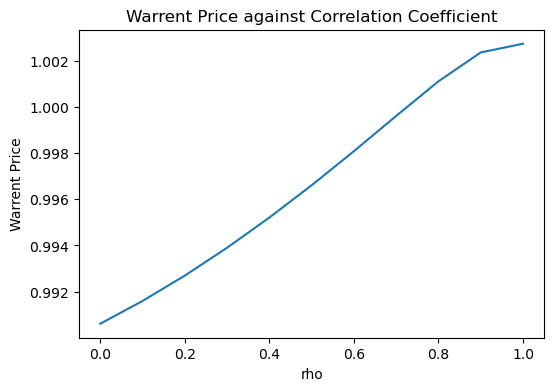

In [6]:
plt.figure(figsize=(6,4))
plt.plot(rho_set, W_rho)
plt.xlabel('rho')
plt.ylabel('Warrent Price')
plt.title("Warrent Price against Correlation Coefficient")
plt.show()

**The result fits our expectation, when the stocks are more related, the chance for a worst performence is reduced. The extreme example is $\rho=0$ and $\rho=1$, the worst of two stocks is always worse than the worst of one stock.**

### 2.2 Volatility of the Stock Prices

**The Parameters are:**

Continuos interest rate: $r = 0.02$

Volitility of $S_1$: $\sigma_1 = 0.1,0.2,...,0.9$

Volitility of $S_2$: $\sigma_2 = 0.1,0.2,...,0.9$

Correlation coefficientof $S_1$ and $S_2$: $\rho = 0.1$

Free Parameter: $\lambda = \sqrt{1.25}$

In [7]:
r = 0.02
sigma1_set = np.linspace(0.1,0.9,9)
sigma2_set = np.linspace(0.1,0.9,9)
sigma1, sigma2 = np.meshgrid(sigma1_set, sigma2_set)
rho = 0.1
W_sigma = np.zeros((sigma1.shape))

start_time = time.time()
for i in range(sigma1.shape[0]):
    for j in range(sigma1.shape[1]):
        W_sigma[i,j] = calc(r, sigma1[i,j], sigma2[i,j], rho)
end_time = time.time()
print(f'time: {end_time - start_time} s\n')

Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatat

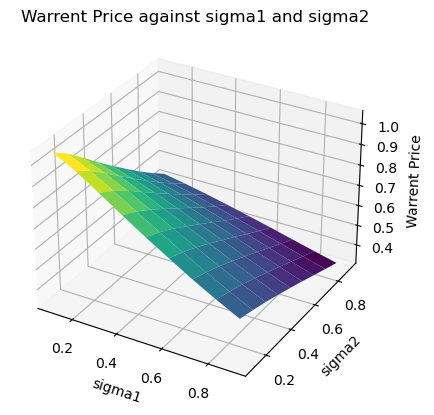

In [8]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(sigma1, sigma2, W_sigma,cmap='viridis', edgecolor='none')
ax.set_xlabel('sigma1')
ax.set_ylabel('sigma2')
ax.set_zlabel('Warrent Price')
ax.set_title('Warrent Price against sigma1 and sigma2')
plt.show()

**The result fits our expectation, when the stocks are more volatile, the chance for a worst performence is increased. The amazing thing is that the price is decreased in a bilinear mode. The coeffects of two stocks's volatilities do not appear.**

### 2.3 Riskless Interest Rate

**The Parameters are:**

Continuos interest rate: $r = 0.00,0.01,...,0.10$

Volitility of $S_1$: $\sigma_1 = 0.1$

Volitility of $S_2$: $\sigma_2 = 0.2$

Correlation coefficientof $S_1$ and $S_2$: $\rho = 0.1$

Free Parameter: $\lambda = \sqrt{1.25}$

In [9]:
sigma1 = 0.1
sigma2 = 0.2
rho = 0.1
r_set = np.linspace(0,0.1,11)
W_r = []

start_time = time.time()
for r in r_set:
    W_r.append(calc(r, sigma1, sigma2, rho))
end_time = time.time()
print(f'time: {end_time - start_time} s\n')

Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
time: 6.367997884750366 s



In [10]:
W_r

[1.0078911043128902,
 1.0004424994258982,
 0.9915959785175317,
 0.9809563585444581,
 0.9676786188894797,
 0.9501225195995169,
 0.9317384704895982,
 0.9128024306674047,
 0.8935044008196785,
 0.8740101291687555,
 0.8544600473843257]

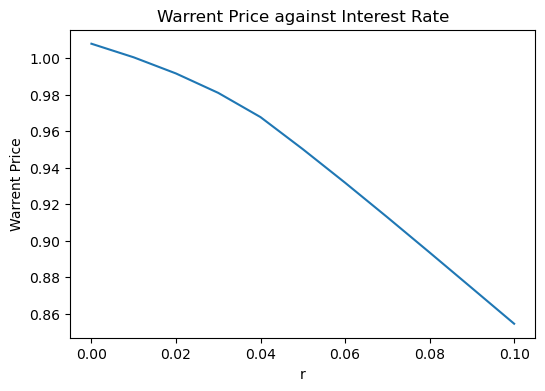

In [11]:
plt.figure(figsize=(6,4))
plt.plot(r_set, W_r)
plt.xlabel('r')
plt.ylabel('Warrent Price')
plt.title("Warrent Price against Interest Rate")
plt.show()

**The result fits our expectation, when the interest rate is higher, this coupon based product obviously less atrractive. The effect is huge since coupon is directly compared with interest rate.**

## 3 Examine the variation of the warrant’s price without call right

In [12]:
@numba.jit(nopython=True)
def calc_nocall(r, sigma1, sigma2, rho):
    N_1year = 252
    N_2year = 504 # The maturity is 2 year
    N_obs = 63
    c_rate = 0.04075 # Coupon rate
    c_day = 0.04075 / N_1year
    K = 0.87 # Exercise price / Reference Price
    call_price = 1. # Call price
    dt = 1. / N_1year
    R = np.exp(-r*dt) # we prefer multiply than divide
    lmd = np.sqrt(1.25) # free parameter, we set (1.25)^0.5 by referencing experiments of Kamrad and Ritchken(1991)
    v1 = lmd * sigma1 * np.sqrt(dt)
    v2 = lmd * sigma2 * np.sqrt(dt)
    u1 = np.exp(v1)
    d1 = 1. / u1
    u2 = np.exp(v2)
    d2 = 1. / u2
    puu = ((1.+ rho)/lmd**2 + np.sqrt(dt)*((r-sigma1**2/2)/sigma1 + (r-sigma2**2/2)/sigma2)/lmd)/4.
    pud = ((1.- rho)/lmd**2 + np.sqrt(dt)*((r-sigma1**2/2)/sigma1 - (r-sigma2**2/2)/sigma2)/lmd)/4.
    pdd = ((1.+ rho)/lmd**2 + np.sqrt(dt)*(-(r-sigma1**2/2)/sigma1 - (r-sigma2**2/2)/sigma2)/lmd)/4.
    pdu = ((1.- rho)/lmd**2 + np.sqrt(dt)*(-(r-sigma1**2/2)/sigma1 + (r-sigma2**2/2)/sigma2)/lmd)/4.
    p00 = 1 - 1./lmd**2

    # ininial Smin, W, W_
    Smin = np.zeros((2*N_2year+1, 2*N_2year+1),dtype=np.double) # min(S1/S1_exer, S2/S2_exer) for efficience of calculation
    W = np.zeros((2*N_2year+1, 2*N_2year+1),dtype=np.double) # Warrent price for state n
    W_ = np.zeros((2*N_2year+1, 2*N_2year+1),dtype=np.double) # Warrent price for state n+1
    
    # determine Smin
    for i in range(-N_2year, N_2year+1):
        for j in range(-N_2year, N_2year+1):
            Smin[i, j] = min(u1 ** i, u2 ** j)
    Smin /= K
    
    # pricing warrents of the last day
    for i in range(-N_2year, N_2year+1):
        for j in range(-N_2year, N_2year+1):
            W_[i, j] = 1. - max(0, 1-Smin[i, j]) + c_day * (Smin[i, j]>=1)
    
    # dynamics program from N_2year - 1 to 0
    for n in range(N_2year-1, -1, -1):
        days_next_obs = N_obs - n % N_obs

        if (days_next_obs == N_obs):
            if n > N_obs:
                for i in range(-n, n+1):
                    for j in range(-n, n+1):
                        W[i, j] = R * (puu * W_[i+1, j+1] + pud * W_[i+1, j-1] + pdd * W_[i-1, j-1] +
                                       pdu * W_[i-1, j+1] + p00 * W_[i, j]) + c_day * (Smin[i, j]>=1)
            elif n == N_obs:
                for i in range(-n, n+1):
                    for j in range(-n, n+1):
                        W[i, j] = R * (puu * W_[i+1, j+1] + pud * W_[i+1, j-1] + pdd * W_[i-1, j-1] +
                                       pdu * W_[i-1, j+1] + p00 * W_[i, j]) + c_day * 4
            else:
                # n == 0
                W[0, 0] = R * (puu * W_[1, 1] + pud * W_[1, -1] + pdd * W_[-1, -1] +
                               pdu * W_[-1, 1] + p00 * W_[0, 0])
                if n==0:
                    print('Computatation Success')

        else:
            if n > N_obs:
                for i in range(-n, n+1):
                    for j in range(-n, n+1):
                        W[i, j] = R * (puu * W_[i+1, j+1] + pud * W_[i+1, j-1] + pdd * W_[i-1, j-1] +
                                       pdu * W_[i-1, j+1] + p00 * W_[i, j]) + c_day * (Smin[i, j]>=1) * np.exp(-r*days_next_obs*dt)
            else:
                for i in range(-n, n+1):
                    for j in range(-n, n+1):
                        W[i, j] = R * (puu * W_[i+1, j+1] + pud * W_[i+1, j-1] + pdd * W_[i-1, j-1] +
                                       pdu * W_[i-1, j+1] + p00 * W_[i, j]) + c_day * 4 * np.exp(-r*days_next_obs*dt)
        W_ = W
        
    return W[0,0]

**We compare with and without Call Right for varing interest rates.The Parameters are:**

Continuos interest rate: $r = 0.00,0.01,...,0.10$

Volitility of $S_1$: $\sigma_1 = 0.1$

Volitility of $S_2$: $\sigma_2 = 0.2$

Correlation coefficientof $S_1$ and $S_2$: $\rho = 0.1$

Free Parameter: $\lambda = \sqrt{1.25}$

In [13]:
sigma1 = 0.1
sigma2 = 0.2
rho = 0.1
r_set = np.linspace(0,0.1,11)
W_nocall_r = []

start_time = time.time()
for r in r_set:
    W_nocall_r.append(calc_nocall(r, sigma1, sigma2, rho))
end_time = time.time()
print(f'time: {end_time - start_time} s\n')

Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
Computatation Success
time: 7.806810140609741 s



In [14]:
W_nocall_r

[1.026222799883973,
 1.0138163547111774,
 0.9998087518411439,
 0.9843811357963902,
 0.9677443540337287,
 0.9501225195995169,
 0.9317384704895982,
 0.9128024306674047,
 0.8935044008196785,
 0.8740101291687555,
 0.8544600473843257]

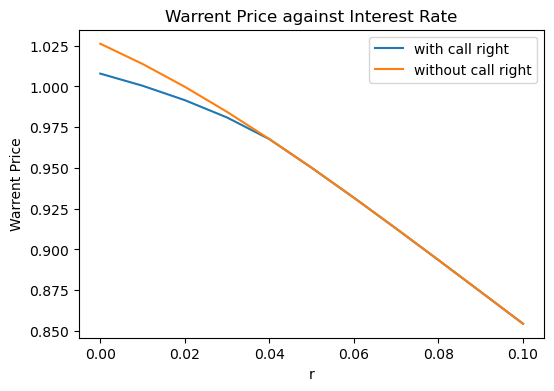

In [15]:
plt.figure(figsize=(6,4))
plt.plot(r_set, W_r,label='with call right')
plt.plot(r_set, W_nocall_r,label='without call right')
plt.xlabel('r')
plt.ylabel('Warrent Price')
plt.title("Warrent Price against Interest Rate")
plt.legend()
plt.show()

**The result fits our expectation, warrent without call right must be more expensive than the one with call right. And when interest rate is high enough, it is always optimal for the issuer not to call back the warrent, since they pay a coupon less than riskless interest rate and the underlying can never larger than 1 (a put for issuer).**